In [14]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
gen = ImageDataGenerator(rotation_range=15, 
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.1, 
                         horizontal_flip=True)

In [16]:
(x_train, t_train), (x_test, t_test) = cifar10.load_data()

In [17]:
x_train = x_train.astype(np.float32)/255
x_test = x_test.astype(np.float32)/255

In [18]:
augment_ratio = 1.5 # 전체 데이터의 150%
augment_size = int(augment_ratio * x_train.shape[0])

print(augment_size)

# 전체 x_train 개수의 150% 비율
randidx = np.random.randint(x_train.shape[0], size=augment_size)

# 임의로 선택된 데이터는 원본 데이터를 참조하기 때문에
# 원본 데이터에 영향을 줄수 있음. 그래서 copy() 함수를 통해 안전하게 복사본 만듬
x_augmented = x_train[randidx].copy()
t_augmented = t_train[randidx].copy()
print(x_augmented.shape, t_augmented.shape)

# 이미지 보강 실행
x_augmented, t_augmented = gen.flow(x_augmented, t_augmented,
                                    batch_size=augment_size,
                                    shuffle=False).next()
print(x_augmented.shape, t_augmented.shape)

75000
(75000, 32, 32, 3) (75000, 1)
(75000, 32, 32, 3) (75000, 1)


In [19]:
# x_train, t_train 에 보강된 데이터 추가
x_train = np.concatenate((x_train, x_augmented))
t_train = np.concatenate((t_train, t_augmented))

print(x_train.shape, t_train.shape)

(125000, 32, 32, 3) (125000, 1)


In [20]:
cnn = Sequential()
cnn.add(Conv2D(input_shape=(32, 32, 3), kernel_size=(3, 3), padding='same', filters=32, activation='relu')) # cnn.add(Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(32, 32, 3)))
cnn.add(Conv2D(kernel_size=(3, 3), filters=32, padding='same', activation='relu')) # cnn.add(Conv2D(32,(3,3), activation='relu', padding='same'))
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(kernel_size=(3, 3), filters=64, padding='same', activation='relu'))
cnn.add(Conv2D(kernel_size=(3, 3), filters=64, padding='same', activation='relu'))
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

# cnn.add(Conv2D(kernel_size=(3, 3), filters=128, padding='same', activation='relu'))
# cnn.add(Conv2D(kernel_size=(3, 3), filters=128, padding='same', activation='relu'))
# cnn.add(MaxPool2D(pool_size=(2, 2)))
# cnn.add(Dropout(0.25))

# cnn.add(Conv2D(kernel_size=(3, 3), filters=256, padding='same', activation='relu'))
# cnn.add(MaxPool2D(pool_size=(2, 2)))
# cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(10, activation='softmax'))

cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [23]:
from datetime import datetime

start_time = datetime.now()

cnn.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 손실함수가 5 epochs을 진행을 검사하여 더이상 줄어들지 않으면 종료
# EarlyStopping(모니터링 값, 대기 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# 학습 중인 모델을 자동 저장
model_checkpoint = ModelCheckpoint(filepath='bast.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True)

hist = cnn.fit(x_train, t_train, batch_size=256, epochs=50, validation_data=(x_test, t_test), callbacks=[early_stopping, model_checkpoint])

end_time = datetime.now()
print(end_time-start_time)

Epoch 1/50
489/489 [==============================] - ETA: 0s - loss: 0.8906 - accuracy: 0.6892
Epoch 1: val_loss improved from inf to 0.68494, saving model to bast.h5
489/489 [==============================] - 11s 20ms/step - loss: 0.8906 - accuracy: 0.6892 - val_loss: 0.6849 - val_accuracy: 0.7581
Epoch 2/50
487/489 [============================>.] - ETA: 0s - loss: 0.8621 - accuracy: 0.6986
Epoch 2: val_loss improved from 0.68494 to 0.66823, saving model to bast.h5
489/489 [==============================] - 10s 20ms/step - loss: 0.8619 - accuracy: 0.6987 - val_loss: 0.6682 - val_accuracy: 0.7679
Epoch 3/50
487/489 [============================>.] - ETA: 0s - loss: 0.8305 - accuracy: 0.7103
Epoch 3: val_loss improved from 0.66823 to 0.66755, saving model to bast.h5
489/489 [==============================] - 10s 20ms/step - loss: 0.8307 - accuracy: 0.7102 - val_loss: 0.6676 - val_accuracy: 0.7671
Epoch 4/50
488/489 [============================>.] - ETA: 0s - loss: 0.8063 - accuracy: 

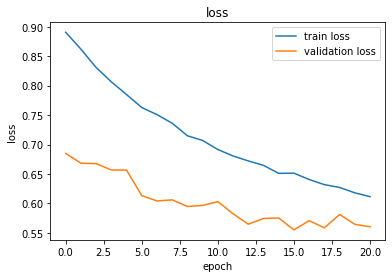

In [25]:
import matplotlib.pyplot as plt

plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend(loc='best')

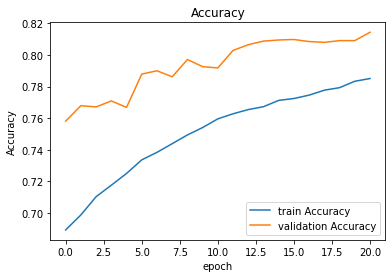

In [26]:
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.plot(hist.history['accuracy'], label='train Accuracy')
plt.plot(hist.history['val_accuracy'], label='validation Accuracy')
plt.legend(loc='best')